# Projet ISOC 731

### **Forray Gabriel** & **Cochard Antoine**

##### Installations and imports

In [1]:
#pip install matplotlib

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from typing import List  
from dataclasses import dataclass  


## 1 - Random graph

In [6]:
options = {
    "font_size": 10,
    "node_size": 300,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 1,
    "width": 1,
}

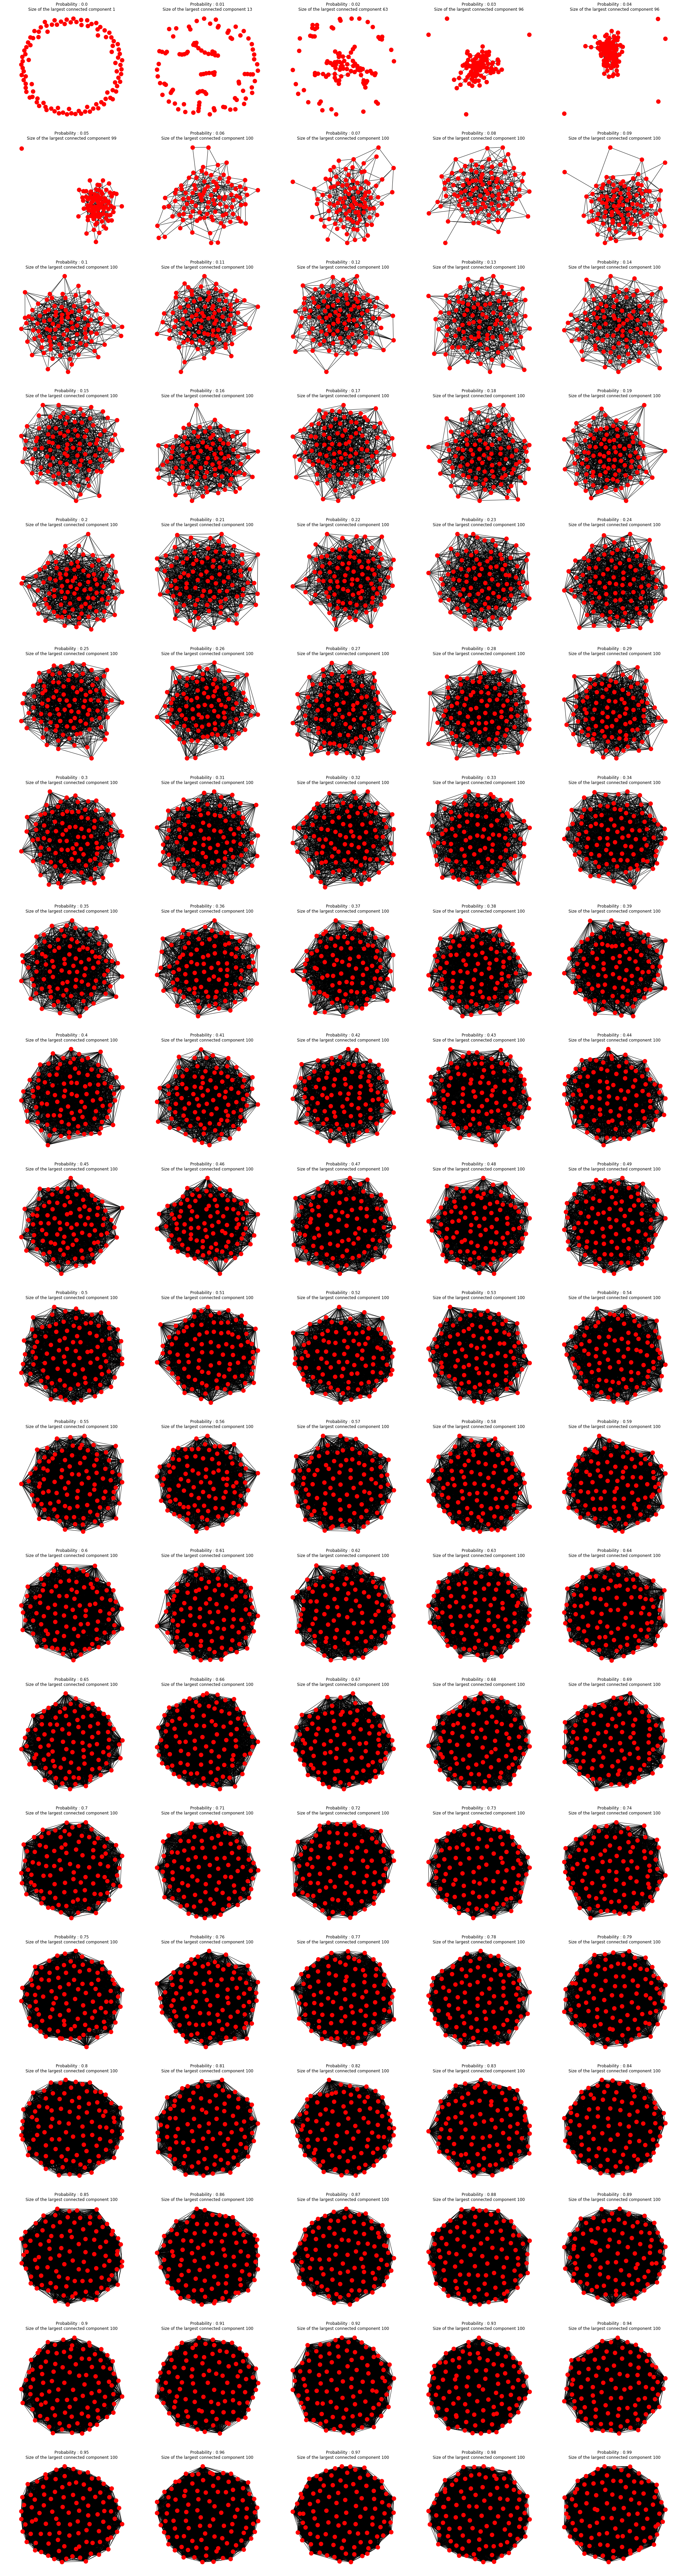

In [7]:
n = 100
p = 0.1

x = []
y = []

Gs = []

def generatGraph(p, ax):
    G = nx.fast_gnp_random_graph(100,p)
    Gs.append(G)
    nx.draw_networkx(G, ax=ax, node_size=150, with_labels = False)
    largest = len(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    ax.set_title("Probability : " + str(p) + "\nSize of the largest connected component " + str(largest))
    ax.axis("off")
    x.append(p)
    y.append(largest)

fig, axs = plt.subplots(20,5,figsize=(35,140))



for i in range(100):
    generatGraph(i/100, axs[i//5, i%5])


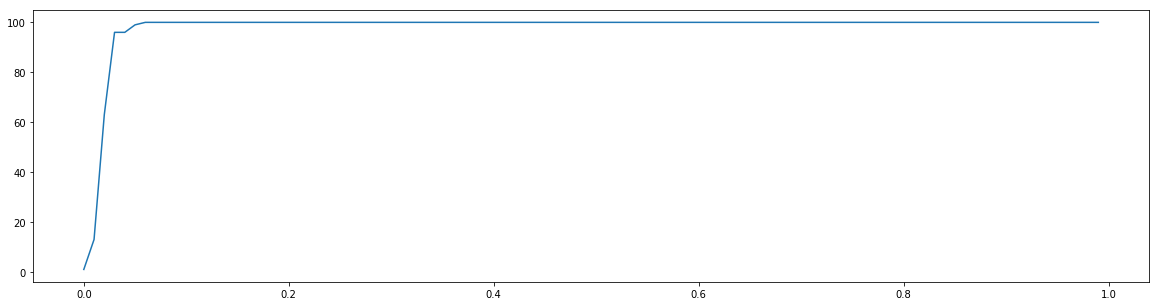

In [8]:
plt.plot(x,y)
fig = plt.gcf()
fig.set_size_inches(20, 5)

On remarque que très vite, à partir de 5% ou 6% de probabilitée, tous les noeuds sont connectés entre eux.

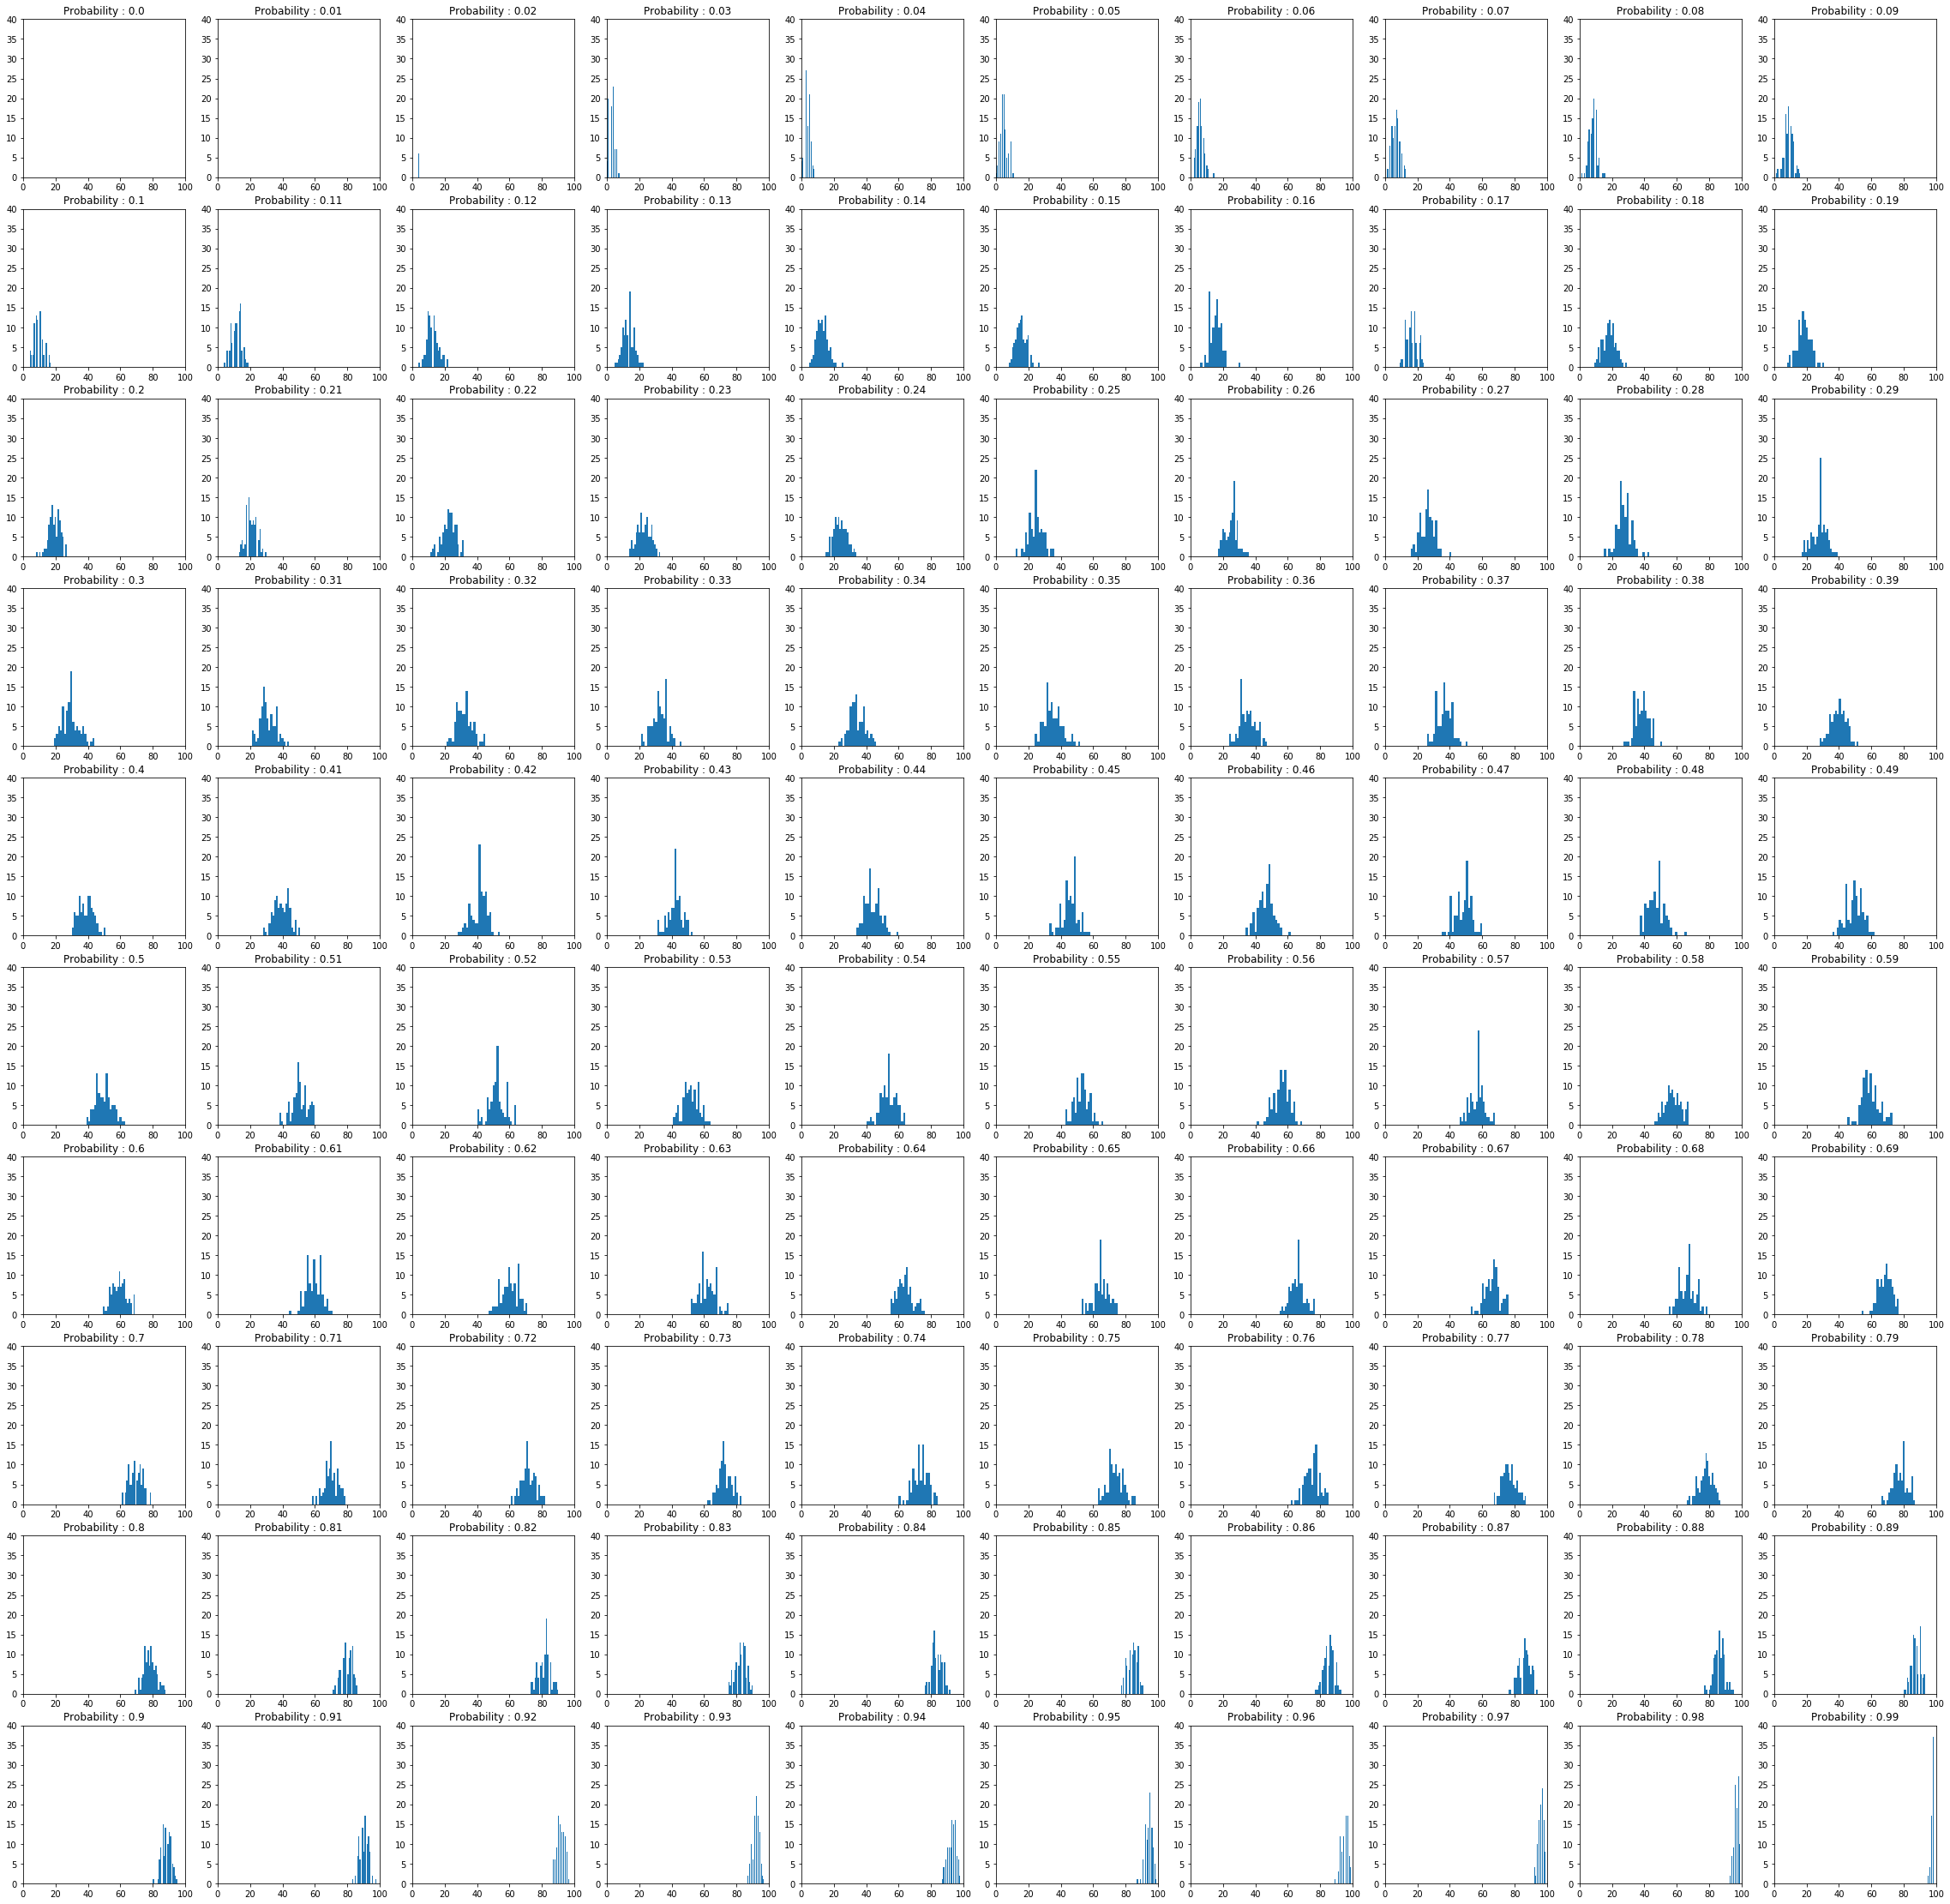

In [9]:
def plot_degree_dist(G, ax, p):
    degrees = [G.degree(n) for n in G.nodes()]
    ax.set(xlim=(0, 100), ylim=(0, 40))
    ax.hist(degrees, bins=20)
    ax.set_title("Probability : " + str(p))

fig, axs = plt.subplots(10,10,figsize=(40,40))

i=0
for G in Gs:
    plot_degree_dist(G, axs[i//10, i%10], i/100)
    i += 1



On peut remarquer grâce à ces graphiques que le nombre moyen de voisins augmente quand la probabilité augmente. Il suffit de voir la "masse" bleu se déplacer doucement vers la droite au fur et à mesure que l'on augmente la probabilité que chaque noeud a de se relier aux autres. Logiquement donc, quand un noeud a peu de chances de créer des liens, le nombre moyen est faible voir nul pour la probabilité égale à 0. A la fin la probabilité approchant 1, le nombre de liaisons approche le nombre de noeuds total.

## 2 - Simple graph formation game

### Without interferences

In [10]:
@dataclass
class Node(object):   
    ID: int   
    Value: int  
    Timing: float
    NodeConnected: int
    Karma: float

def findNode(list, id):
    for n in list:
        if n.ID == id:
            return n   

First Node :  Node(ID=3, Value=0, Timing=0.026994638414728933, NodeConnected=-1, Karma=0)
First random Node :  Node(ID=1, Value=0, Timing=0.06825774457203204, NodeConnected=-1, Karma=0)


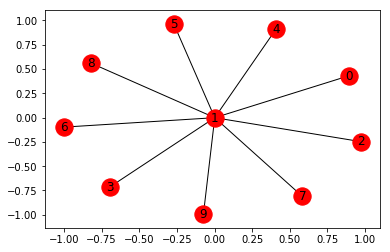

In [11]:
def simple_game_without_interference(): 
    G = nx.Graph()

    Nodes = []

    n = 10

    # We create n nodes, each one has an id, a value initialized to 0 and a random timing value
    # Then we add them to the graph
    for i in range(n):
        node = Node(i, 0, random.random(), -1 ,0)
        Nodes.append(node)
        G.add_node(i, data = Node)

    # We sort the nodes by the timing value to determine the order in which the nodes will play
    Nodes = sorted(Nodes, key=lambda x: x.Timing)

    print("First Node : ", Nodes[0])

    # For each node
    for nodePlaying in Nodes:
        # We take the node by timing order
        
        # We make a list of nodes to which the playing node can connect (every node except him)
        index = Nodes.index(nodePlaying)
        selectableNodes = Nodes[:index]+ Nodes[index+1:]

        # We search for the maximum value in any nodes
        maxValue = max(selectableNodes, key = lambda node:node.Value).Value

        # If the max value is 0, there are no connections
        if maxValue == 0:
            # We get a random node
            nodeRandom = random.choice(selectableNodes)

            print("First random Node : ", nodeRandom)

            # We make the connection between the randomly selected node and the one with the lowest timing and set their values to 1
            G.add_edge(nodePlaying.ID, nodeRandom.ID)
            nodePlaying.Value = 1
            nodeRandom.Value = 1
        
        else:
            # We make a list of nodes that have the maximum value
            listMaxNodes = []
            for n in selectableNodes:
                if n.Value == maxValue:
                    listMaxNodes.append(n)
            
            # We select a random node between them
            nodeToConnect = random.choice(listMaxNodes)

            # If the nodes are not already connected, we connect them and increase their values
            if G.has_edge(nodePlaying.ID,nodeToConnect.ID) == False :

                G.add_edge(nodePlaying.ID, nodeToConnect.ID)
                
                if G.degree(nodePlaying.ID) == 1:
                    nodePlaying.Value = 1
                
                if G.degree(nodeToConnect.ID) == 1:
                    nodeToConnect.Value = 1

                if G.degree(nodePlaying.ID) > 1:
                    neighbors = G[nodePlaying.ID]
                    nodePlaying.Value = 0
                    for neighbor in neighbors:
                        nodePlaying.Value += findNode(Nodes, neighbor).Value
                
                if G.degree(nodeToConnect.ID) > 1:
                    neighbors = G[nodeToConnect.ID]
                    nodeToConnect.Value = 0
                    for neighbor in neighbors:
                        nodeToConnect.Value += findNode(Nodes, neighbor).Value



    nx.draw_networkx(G)

simple_game_without_interference()

We can see that in every simulations, there is always one node in the center with all the other nodes connected to it. It is always either be the node with the lowest timing or the first randomnlly choosed Node.  
It is like that because, when the second Node is choosing, they are the only two with a value of 1 instead of 0. The second Node will randomnly choose one of the two, increasing its value. Then this node will always be selected and increased at each step.  
### With inerference

In [129]:
def simple_game_wit_interference(ax, interference, iteration):
    G = nx.Graph()

    Nodes = []

    n = 100

    # We create n nodes, each one has an id, a value initialized to 0 and a random timing value
    # Then we add them to the graph
    for i in range(n):
        #node = Node(i, 0, random.random(), -1, 1)
        node = Node(i, 0, i/100, -1, 0)
        Nodes.append(node)
        G.add_node(i)

    # We sort the nodes by the timing value to determine the order in which the nodes will play
    Nodes = sorted(Nodes, key=lambda x: x.Timing)

    first = "First Node : " +  str(Nodes[0].ID)

    # For each node
    for nodePlaying in Nodes:
        # We take the node by timing order
        
        # We make a list of nodes to which the playing node can connect (every node except him)
        index = Nodes.index(nodePlaying)
        selectableNodes = Nodes[:index]+ Nodes[index+1:]

        # We search for the maximum value in any nodes
        maxValue = max(selectableNodes, key = lambda node:node.Value).Value

        # If the max value is 0, there are no connections
        if maxValue == 0:
            # We get a random node
            nodeRandom = random.choice(selectableNodes)

            # We make the connection between the randomly selected node and the one with the lowest timing and set their values to 1
            G.add_edge(nodePlaying.ID, nodeRandom.ID)
            nodePlaying.NodeConnected = nodeRandom.ID
            nodePlaying.Value = 1
            nodeRandom.Value = 1
        
        else:
            #Searching for the Node with the maximum vizible value
            nodeToConnect = None
            maxValue = 0
            for n in selectableNodes:
                #Wwhen looking for the value, modifying it with the interferences
                interferedValue = n.Value*random.randint(100-interference,100+interference)/100
                if interferedValue > maxValue:
                    maxValue = interferedValue
                    nodeToConnect = n

            nodePlaying.NodeConnected = nodeToConnect.ID


            # If the nodes are not already connected, we connect them and increase their values
            if G.has_edge(nodePlaying.ID,nodeToConnect.ID) == False :

                G.add_edge(nodePlaying.ID, nodeToConnect.ID)

                if G.degree(nodePlaying.ID) == 1:
                    nodePlaying.Value = 1
                
                if G.degree(nodeToConnect.ID) == 1:
                    nodeToConnect.Value = 1

                if G.degree(nodePlaying.ID) > 1:
                    neighbors = G[nodePlaying.ID]
                    nodePlaying.Value = 0
                    for neighbor in neighbors:
                        nodePlaying.Value += findNode(Nodes, neighbor).Value
                
                if G.degree(nodeToConnect.ID) > 1:
                    neighbors = G[nodeToConnect.ID]
                    nodeToConnect.Value = 0
                    for neighbor in neighbors:
                        nodeToConnect.Value += findNode(Nodes, neighbor).Value


    maxNode = None
    maxValue = 0
    for n in Nodes:
        if n.Value>maxValue:
            maxNode = n
            maxValue = n.Value
    colorMap = []
    color = 17
    for n in Nodes:
        if n.ID == maxNode.ID:
            colorMap.append('#48EB00')
        else :
            if iteration%2 == 0:
                colorMap.append('#76519E')
            else :
                colorMap.append('#EB110C')
           
    nx.draw_networkx(G, node_color=colorMap, ax=ax, node_size=150, with_labels = False)    
    ax.axis('off')   
    return G, Nodes


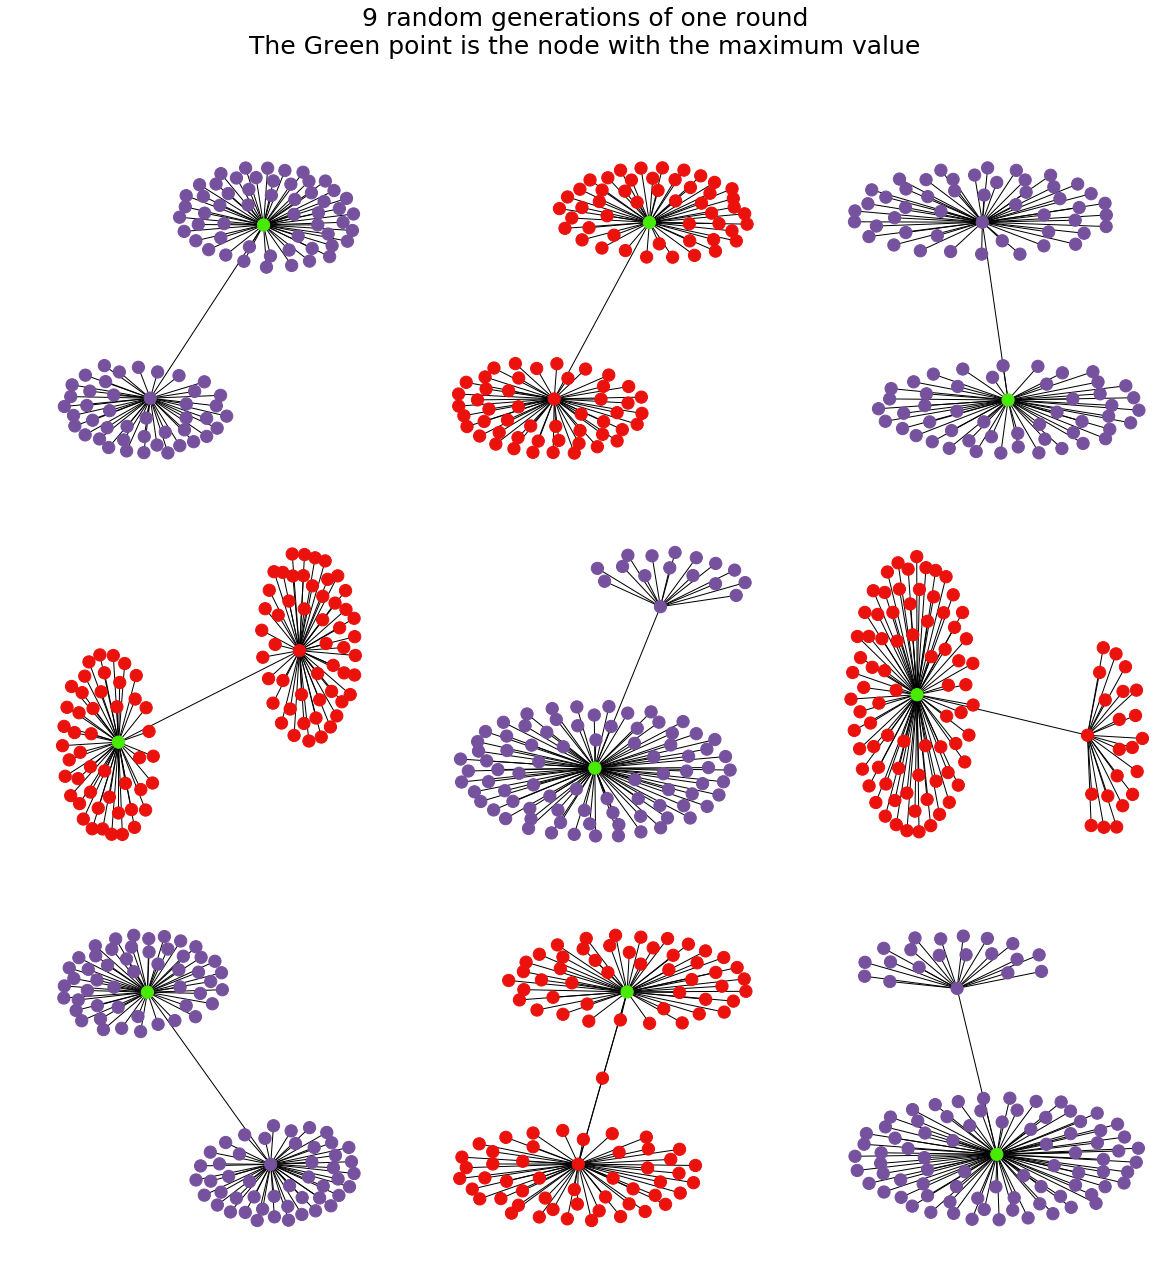

In [131]:
fig, axs = plt.subplots(3,3,figsize=(20,20))

fig.suptitle("9 random generations of one round\nThe Green point is the node with the maximum value", fontsize=25)

for i in range(9):
    simple_game_wit_interference(axs[i//3, i%3], 99, i)

## 3 - More advanced graph formation game

In [14]:
def find_node(Nodes, ID):
    for n in Nodes:
        if n.ID == ID:
            return n
    return Node(-1, -100, i/100, -1, 1)

In [71]:
def next_round(ax, interference, G, Nodes, karma_incr, iteration):
    
    # For each node
    for nodePlaying in Nodes:
        # We take the node by timing order
        # We make a list of nodes to which the playing node can connect (every node except him)
        index = Nodes.index(nodePlaying)
        selectableNodes = Nodes[:index]+ Nodes[index+1:]

        
        #Searching for the Node with the maximum vizible value
        nodeToConnect = Node(i, 0, i/100, -100, 0)
        maxValue = 0
        for n in selectableNodes:
            #Wwhen looking for the value, modifying it with the interferences
            interferedValue = n.Value*random.randint(100-interference,100+interference)/100
            if interferedValue > maxValue:
                maxValue = interferedValue
                nodeToConnect = n
        #Finding the node which we are already connected to
        node_already_connected = find_node(Nodes, nodePlaying.NodeConnected)
        if node_already_connected.Value < nodeToConnect.Value:
            if G.has_edge(nodePlaying.ID, node_already_connected.ID):
                G.remove_edge(nodePlaying.ID, node_already_connected.ID)
            
                nodePlaying.Value -= node_already_connected.Value
            
            nodePlaying.Karma += karma_incr

            # If the karma is good enought
            rand = random.random()
            if nodePlaying.Karma< rand:

                G.add_edge(nodePlaying.ID, nodeToConnect.ID)
                nodePlaying.NodeConnected = nodeToConnect.ID

                if G.degree(nodePlaying.ID) == 1:
                    nodePlaying.Value = 1
                    
                if G.degree(nodeToConnect.ID) == 1:
                    nodeToConnect.Value = 1

                if G.degree(nodePlaying.ID) > 1:
                    neighbors = G[nodePlaying.ID]
                    nodePlaying.Value = 0
                    for neighbor in neighbors:
                        nodePlaying.Value += findNode(Nodes, neighbor).Value
                    
                if G.degree(nodeToConnect.ID) > 1:
                    neighbors = G[nodeToConnect.ID]
                    nodeToConnect.Value = 0
                    for neighbor in neighbors:
                        nodeToConnect.Value += findNode(Nodes, neighbor).Value
                
            else :
                nodePlaying.NodeConnected = -1
                nodePlaying.Value=0

                
    maxNode = None
    maxValue = 0
    for n in Nodes:
        if n.Value>maxValue:
            maxNode = n
            maxValue = n.Value
    colorMap = []
    color = 0
    for n in Nodes:
        if n.ID == maxNode.ID:
            colorMap.append(200)
        else :
            colorMap.append(color)
            color +=1

    
    
    nx.draw_networkx(G, node_color=colorMap, ax=ax, node_size=150, with_labels = False)
    largest = len(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    ax.set_title("Iteration number : " + str(iteration) +"\nSize of the largest connected\ncomponent :" + str(largest), fontsize=15)
    ax.axis('off')
    return G, Nodes

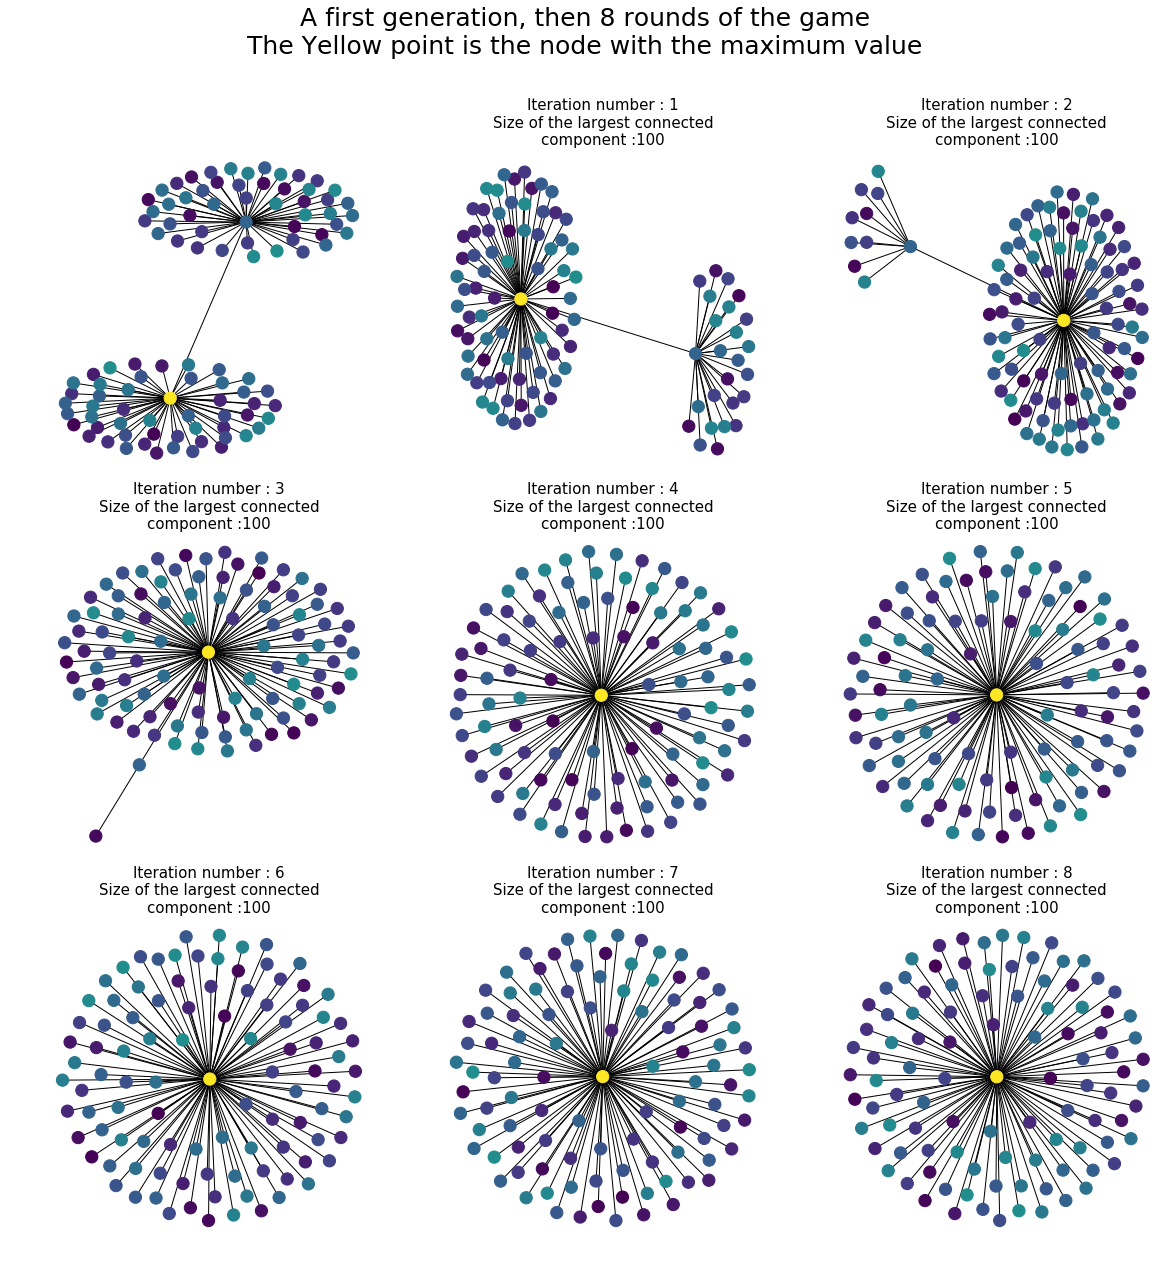

In [72]:
fig, axs = plt.subplots(3,3,figsize=(20,20))


G, Nodes = simple_game_wit_interference(axs[0,0],80)

karma_incr = 0.05

fig.suptitle("A first generation, then 8 rounds of the game\nThe Yellow point is the node with the maximum value", fontsize=25)

for i in range(1,9):
    G, Nodes = next_round(axs[i//3,i%3],interference, G, Nodes, karma_incr, i)